In [1]:
from Utils.egogetter import VideoGetter
import Augmentor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import random
import torch
from Extras.loadconfigs import EMB_DIM, S_LABELS, M_LABELS, LABELS, TANGENT_PATCH
import albumentations as A
from Utils.utils import getPanoRowsImg,getPanoRowsFlow
import equilib as eq
import multiprocessing.pool as pool
from imageio import imread
from itertools import starmap


aug = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.8),
                         A.RandomFog(fog_coef_upper=0.5,p = 0.2),
                        ],
                        additional_targets={f'image{i}': 'image' for i in range(10 - 1)}
                       )

def panofy(kwargs):
    return getPanoRowsImg(**kwargs)

def ParallelPanoRowsImg(img_list):

    args = [dict(img=img, pitch = pitch, roll = roll, yaw = yaw) for img in img_list]
    
    p = pool.Pool(len(img_list))
    imgs = p.map(panofy, args)
    p.close()
    p.join()
    return imgs
    

def readImageParallel(img_list):
    p = pool.Pool(len(img_list))
    imgs = p.map(imread, img_list)
    p.close()
    p.join()
    
    keys = ["image"]+[f"image{i}" for i in range(len(img_list)-1)]
    imdict = dict(zip(keys,imgs))
    augim = aug(**imdict)
    _, augim = zip(*sorted(list(augim.items()), key = lambda x:x))
    
    p = pool.Pool(len(img_list))
    imgs = p.map(Image.fromarray, augim)
    p.close()
    p.join()
    
    C = lambda :random.choice(np.linspace(-np.pi,np.pi,180))
    pitch, roll, yaw = C(), C(), C()
    imgs = list(map(lambda x:getPanoRowsImg(x, pitch = pitch, yaw = yaw, roll = roll), imgs))
    return imgs, pitch, roll, yaw

# def readFlowParallel()

/home/Students/k_b459/miniconda3/envs/torch11/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# out = readImageParallel(dt.data[0]['frame'])

In [5]:
# out[0][9]

In [6]:
# out[3]

In [7]:
# out[0]

In [8]:
# ParallelPanoRowsImg(out)

In [65]:
# out

In [66]:
# imgs

In [67]:
Image.fromarray(out['image0'])

TypeError: tuple indices must be integers or slices, not str

In [68]:
# out['image']

In [69]:
# out[2]

In [70]:
vd['frames']

NameError: name 'vd' is not defined

In [71]:
def f(x):
    return x*x

In [72]:
# p.map?

In [73]:
p = pool.Pool(8)
out = p.map(f, [1,2,3,4])
p.close()
p.join()

In [74]:
out

[1, 4, 9, 16]

In [75]:
class DataCollector(object):
    def __init__(self, 
                 root = "/data/keshav/360/finalEgok360/data/",
                 mode = "test",
                 shuffle = True,
                 n = 4, 
                 w = 640, 
                 h = 320,
                 siamese=False, 
                 ignoreFocus = False):
        self.n = n
        self.w = w
        self.h = h
        self.siamese = siamese
        self.aug = self.albAugmentor(n)
        self.actMapper = self.getMapGenerator()
        self.data = VideoGetter(root = root, mode = mode, nwor = n, shuffle = shuffle)
        
        self.imgTransform = T.Compose([T.ToTensor(), 
                                       T.Normalize(mean=[0.485, 0.456, 0.406], 
                                                   std=[0.229, 0.224, 0.225],
                                                  ),
                                      ])
        self.floTransform = T.Compose([T.Normalize(mean=[0.485, 0.456], 
                                                   std=[0.229, 0.224],
                                                  ),
                                      ])
    
    def albAugmentor(self, num_imgs):
        aug = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.8),
                         A.RandomFog(fog_coef_upper=0.5,p = 0.2),
                        ],
                        additional_targets={f'image{i}': 'image' for i in range(num_imgs - 1)}
                       )
        return aug
    
    def mapAugMentation(self, img_list, aug):
        img_list = list(map(np.asarray,map(Image.open, img_list)))
        keys = ['image']+[f"image{i}" for i in range(len(img_list)-1)]
        augargs = dict(zip(keys, img_list))
        out = aug(**augargs)
        aug_img = [Image.fromarray(out[k]) for k in keys]
        return aug_img
    
    def focusGenerator(self, w = 640, h = 320):
        u,v = np.meshgrid(np.linspace(1,-1,w), np.linspace(1,-1,h))
        radi = (u**2 + v**2)**0.5
        radi = radi/radi.max()
        radi = abs(radi -1 )
        radi = torch.from_numpy(radi)[None,:]
        radi = eq.equi2equi(radi, rots = {'pitch':-np.pi/2, 'yaw':0, 'roll':0})
        return radi
    
    def getMapGenerator(self):
        con = torch.nn.Conv2d(in_channels=1, 
                              out_channels=EMB_DIM, 
                              kernel_size=64, 
                              stride=64, 
                              bias=False).requires_grad_(False)
        con.weight.data = torch.ones_like(con.weight.data).type(con.weight.data.dtype)
        return con
    
    def mapFocusWithConv(self, mapper, focus):
        overlay = mapper(focus.unsqueeze(0))
        overlay = overlay.view(1,-1,6).permute(0,2,1)
        return overlay
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        frames = data['frame']
        flows = data['flow']
        
        flow_list = [np.load(f) for f in flows]
        
        img_list = self.mapAugMentation(frames, self.aug)
        rotargs = {'pitch':None, 'yaw':None, 'roll':None}
        
        sample = {}
        
        img_list_1 = []
        flow_list_1 = []
        for i, img in enumerate(img_list):
            temp, rotargs = getPanoRowsImg(img = img, face_w = TANGENT_PATCH, return_rot_args = True, **rotargs)
            img_list_1.append(temp)
        
        for i, flow in enumerate(flow_list):
            temp = getPanoRowsFlow(flow = flow, face_w = TANGENT_PATCH, return_rot_args = False, **rotargs)
            flow_list_1.append(temp)
        if not self.ignoreFocus:
            focus_1 = eq.equi2equi(self.focusGenerator(w=self.w, h=self.h), rots=rotargs)
            focus_1 = self.actMapper(focus_1[None,:].float())
        
        if self.siamese:
            img_list_2 = []
            flow_list_2 = []
            
            rotargs = {'pitch':None, 'yaw':None, 'roll':None}
            for i, img in enumerate(img_list):
                temp, rotargs = getPanoRowsImg(img = img, face_w = TANGENT_PATCH, return_rot_args = True, **rotargs)
                img_list_2.append(temp)
        
            for i, flow in enumerate(flow_list):
                temp = getPanoRowsFlow(flow = flow, face_w = TANGENT_PATCH, return_rot_args = False, **rotargs)
                flow_list_2.append(temp)
            
            if not self.ignoreFocus:
                focus_2 = eq.equi2equi(self.focusGenerator(w=self.w, h=self.h), rots=rotargs)
                focus_2 = self.actMapper(focus[None,:].float())
            
            imgs_2 = list(map(self.imgTransform, img_list_2))
            imgs_2 = torch.stack(imgs_2, 1)
            
            flows_2 = [self.floTransform(torch.from_numpy(f).permute(2,0,1)) for f in flow_list_2]
            flows_2 = torch.stack(flows_2, 1)
            
            sample['img_2'] = imgs_2
            sample['flow_2'] = flows_2
            if not self.ignoreFocus:
                sample['focus_2'] = focus_2
        
        imgs_1 = list(map(self.imgTransform, img_list_1))
        imgs_1 = torch.stack(imgs_1, 1)
        
        flows_1 = [self.floTransform(torch.from_numpy(f).permute(2,0,1)) for f in flow_list_1]
        flows_1 = torch.stack(flows_1, 1)
        
        sample['img_1'] = imgs_1
        sample['flow_1'] = flows_1
        
        if not self.ignoreFocus:
            sample['focus_1'] = focus_1
        
        sample['s_label'] = S_LABELS[data['s_label']]
        sample['m_label'] = M_LABELS[data['m_label']]
        sample['label'] = LABELS[data['label']]
        
        return sample        

In [76]:
dt = DataCollector()

In [77]:
import PIL
# isinstance(dt[0][0],PIL.Image.Image)

In [83]:
dt[0]['flow_1'].shape

torch.Size([2, 4, 128, 192])

In [57]:
# a.max()

In [58]:
plt.hist(a.numpy().reshape(-1)/a.max())

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f19dd6233a0> (for post_execute):


KeyboardInterrupt: 

In [44]:
type(dt[0][0])

PIL.Image.Image

In [25]:
eq.equi2equi(foci, *args)

torch.Size([1, 320, 640])

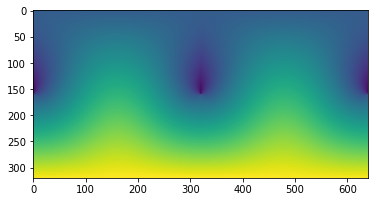

In [24]:
plt.imshow(foci[0])

In [785]:
# VideoGetter?

In [2]:
root = "/data/keshav/360/finalEgok360/data/"
vd = VideoGetter(root = "/data/keshav/360/finalEgok360/data/", mode = 'test', shuffle = True)

In [3]:
vd[0]

{'s_label': 'standing',
 'm_label': 'standing',
 'label': 'standing_standing',
 'frame': [PosixPath('/data/keshav/360/finalEgok360/data/Standing/Standing/test/frames/00020/0060.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/Standing/Standing/test/frames/00020/0061.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/Standing/Standing/test/frames/00020/0062.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/Standing/Standing/test/frames/00020/0063.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/Standing/Standing/test/frames/00020/0064.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/Standing/Standing/test/frames/00020/0065.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/Standing/Standing/test/frames/00020/0066.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/Standing/Standing/test/frames/00020/0067.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/Standing/Standing/test/frames/00020/0068.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/

In [40]:
sorted(["image", "image0", "image2", "image1"])

['image', 'image0', 'image1', 'image2']

In [5]:
img = Image.open(vd[420]['frame'][0])

In [6]:
aug = albAugmentor(3)

In [15]:
aug(image = np.asarray(img),image0 = np.asarray(img))

{'image': array([[[195, 201, 197],
         [195, 201, 197],
         [195, 201, 197],
         ...,
         [197, 203, 199],
         [197, 203, 199],
         [197, 203, 199]],
 
        [[195, 201, 197],
         [195, 201, 197],
         [195, 201, 197],
         ...,
         [197, 203, 199],
         [197, 203, 199],
         [197, 203, 199]],
 
        [[199, 205, 201],
         [199, 205, 201],
         [199, 205, 201],
         ...,
         [199, 205, 201],
         [199, 205, 201],
         [199, 205, 201]],
 
        ...,
 
        [[ 43,   9,  10],
         [ 43,   9,  10],
         [ 43,   9,  10],
         ...,
         [ 42,   8,   9],
         [ 42,   8,   9],
         [ 42,   8,   9]],
 
        [[ 41,  10,   8],
         [ 42,  11,   9],
         [ 42,  10,  11],
         ...,
         [ 40,   8,   9],
         [ 40,   8,   9],
         [ 39,   7,   8]],
 
        [[ 40,   9,   7],
         [ 41,  10,   8],
         [ 42,  11,   9],
         ...,
         [ 39,   7,

In [719]:
# 

In [720]:
# A.RandomBrightnessContrast?

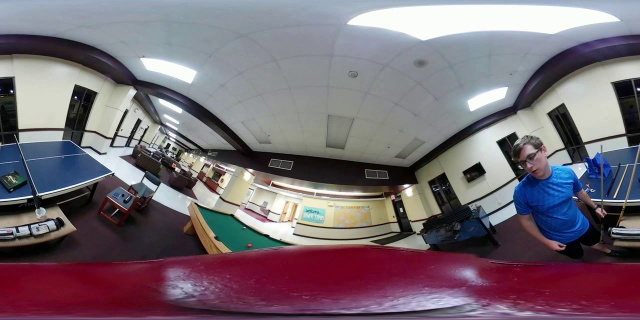

In [721]:
aug = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.8),
                 A.RandomFog(fog_coef_upper=0.5,p = 0.2),
                ],
                additional_targets={'image0': 'image', 'image1': 'image'}
               )
result = aug(image = np.asarray(img), image0 = np.asarray(img))
Image.fromarray(result['image'])

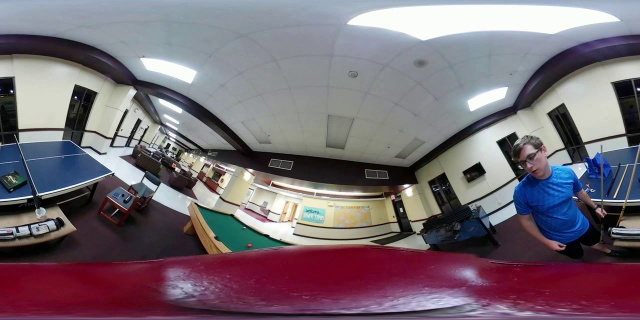

In [722]:
Image.fromarray(result['image0'])

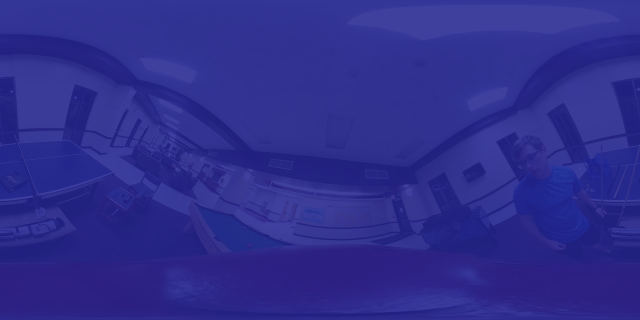

In [723]:
layer = Image.new('RGB', img.size, 'red') # "hue" selection is done by choosing a color...
layer1 = Image.new('RGB', img.size, 'green')
layer2 = Image.new('RGB', img.size, 'blue')
img = Image.blend(img, layer, 0.5)
img = Image.blend(img, layer1, 0.5)
img = Image.blend(img, layer2, 0.5)
img

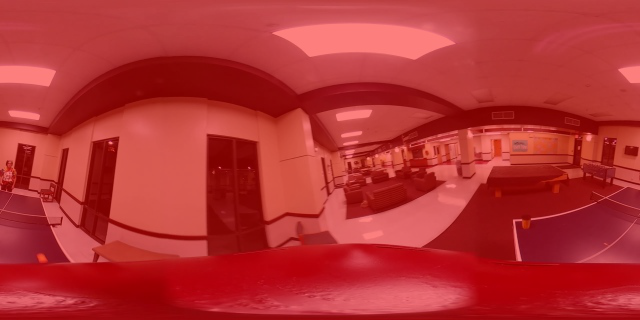

In [724]:
output

In [725]:
jitter = T.ColorJitter(brightness=2, contrast=0.5, saturation=0.5, hue=0.5)

In [726]:
# img

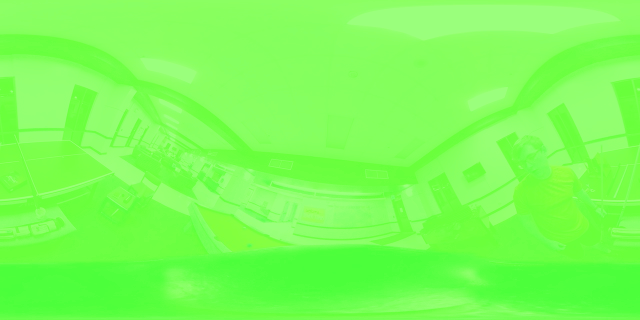

In [727]:
T.ToPILImage()(jitter(T.ToTensor()(img)))

In [728]:
# pipe = Augmentor.Pipeline(vd[420]['frame'][0])

In [729]:
# ls /data/keshav/360/finalEgok360/data/Standing/Standing/test/frames/00004/0070.jpg

In [730]:
# len(vd)

In [731]:
pipe.random_brightness, pipe.random_color, pipe.random_contrast, pipe.random_distortion, pipe.random_erasing

(<bound method Pipeline.random_brightness of <Augmentor.Pipeline.Pipeline object at 0x7fb1af92a520>>,
 <bound method Pipeline.random_color of <Augmentor.Pipeline.Pipeline object at 0x7fb1af92a520>>,
 <bound method Pipeline.random_contrast of <Augmentor.Pipeline.Pipeline object at 0x7fb1af92a520>>,
 <bound method Pipeline.random_distortion of <Augmentor.Pipeline.Pipeline object at 0x7fb1af92a520>>,
 <bound method Pipeline.random_erasing of <Augmentor.Pipeline.Pipeline object at 0x7fb1af92a520>>)

In [756]:
# np.asarray(img)

In [733]:
u,v = np.meshgrid(np.linspace(1,-1,640), np.linspace(1,-1,320))
radi = (u**2 + v**2)**0.5
radi = radi/radi.max()
radi = abs(radi -1 )

In [734]:
import matplotlib.pyplot as plt

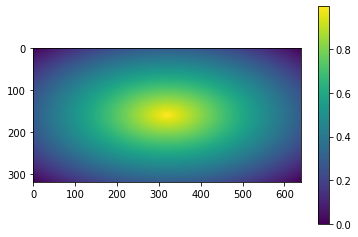

In [735]:

plt.imshow(radi)
plt.colorbar()

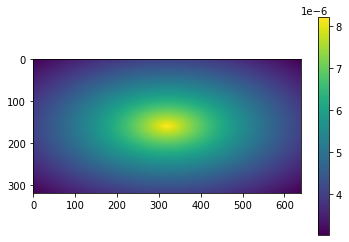

In [736]:
plt.imshow(np.exp(radi)/np.exp(radi).sum())
plt.colorbar()

In [739]:
# plt.hist(radi.reshape(-1))

In [740]:
import equilib as eq
import torch

In [751]:
t = eq.equi2equi(torch.from_numpy(radi).unsqueeze(0), rots = {'pitch':-np.pi/2, 'yaw':0, 'roll':0})
tn = t.numpy()[0]

In [752]:
tn.shape

(320, 640)

In [753]:
# plt.hist(tn, bins = 100)

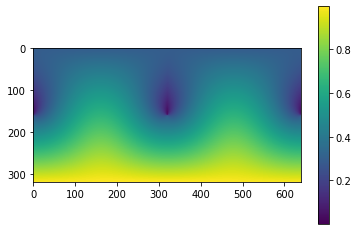

In [755]:
plt.imshow(tn)
plt.colorbar()

In [8]:
vd[0]

{'s_label': ['office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk'],
 'm_label': ['office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk',
  'office_talk'],
 'label': ['office_talk_office_talk',
  'office_talk_office_talk',
  'office_talk_office_talk',
  'office_talk_office_talk',
  'office_talk_office_talk',
  'office_talk_office_talk',
  'office_talk_office_talk',
  'office_talk_office_talk',
  'office_talk_office_talk',
  'office_talk_office_talk'],
 'frame': [PosixPath('/data/keshav/360/finalEgok360/data/Office_talk/Office_talk/test/frames/00007/0090.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/Office_talk/Office_talk/test/frames/00007/0091.jpg'),
  PosixPath('/data/keshav/360/finalEgok360/data/Office_talk/Office_talk/test/frames/00007/0092.jpg'),
  PosixPath('/data/ke